In [1]:
import pandas as pd
import duckdb as ddb
from tsfresh import extract_features
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
con = ddb.connect("../kalam_hydropower.db", read_only=True)

## Clustering Series Together

The idea here was to try reduce the number of series I was dealing with by introducing groups of 'similar' series together. Now this ultimately did not work out for me, however, I think this is valueable because of the use of `tsfresh` and the ease of extracting high level information from a large set of timeseries.

In [3]:
ss_df = con.sql("select * from raw.sample_submission").to_df()
ss_df[["date", "source"]] = ss_df["ID"].str.split("_", n=1, expand=True)


ss_df = con.sql("select * from raw.sample_submission").to_df()
ss_df[["date", "source"]] = ss_df["ID"].str.split("_", n=1, expand=True)

df = con.sql("""
    select
        *
    from prepared.daily_hydropower_production
    where source in (select source from ss_df)
""").to_df()

In [4]:
# This extracts a specific subset of features rather than all the features tsfresh has to offer (which is 100s!)
custom_settings = {
    "mean": None,
    "standard_deviation": None,
    "kurtosis": None,
    "skewness": None,
    "length": None,
    # "autocorrelation": [{"lag": l} for l in [1, 7, 14, 30, 90]],
    "augmented_dickey_fuller": [ {"attr": "pvalue", "autolag": "AIC"}],
}

features_df = extract_features(
    df,
    column_id="source",
    column_sort="date",
    column_value="kwh",
    disable_progressbar=False,
    default_fc_parameters=custom_settings
)

features_df.head()

Feature Extraction: 100%|██████████| 39/39 [00:05<00:00,  6.64it/s]


,kwh__mean,kwh__standard_deviation,kwh__kurtosis,kwh__skewness,kwh__length,"kwh__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC"""
consumer_device_12_data_user_1,0.031671,0.076174,5.231739,2.508237,306.0,0.510110
consumer_device_12_data_user_10,0.021857,0.051789,4.600871,2.404890,306.0,0.481118
consumer_device_12_data_user_11,0.011818,0.030195,7.158803,2.751968,306.0,0.058315
consumer_device_12_data_user_12,0.024224,0.057630,4.671778,2.418948,306.0,0.402209
consumer_device_12_data_user_13,0.025102,0.059641,4.683146,2.419007,306.0,0.424000


<Axes: ylabel='Frequency'>

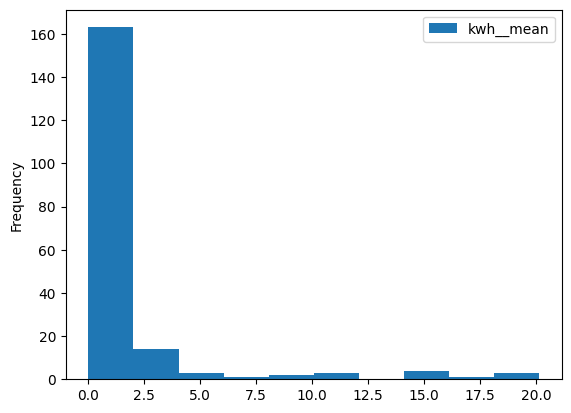

In [8]:
# Plotting the extracted statistics is easier
features_df.plot(kind="hist", y="kwh__mean")

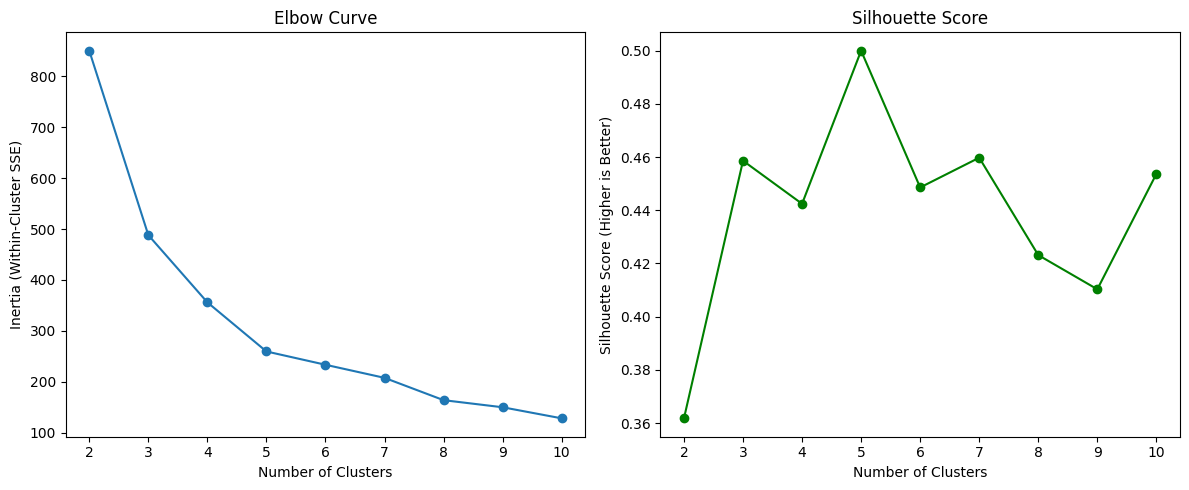

In [6]:
# Here I tried a KMeans clustering of the features extracted to look for high level patterns

# Ensure your features are scaled (important for distance-based clustering)
scaled_features = StandardScaler().fit_transform(features_df.fillna(0))
scaled_features_df = pd.DataFrame(scaled_features, columns=features_df.columns)

# Store results
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(scaled_features_df.fillna(0))
    
    inertia.append(kmeans.inertia_)  # Sum of squared distances to centroids
    silhouette_scores.append(silhouette_score(scaled_features_df.fillna(0), labels))

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow curve
ax[0].plot(k_range, inertia, marker='o')
ax[0].set_title('Elbow Curve')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Inertia (Within-Cluster SSE)')

# Silhouette scores
ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score (Higher is Better)')

plt.tight_layout()
plt.show()

In [16]:
# Fit final KMeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(scaled_features)

# Assign cluster labels back to DataFrame
scaled_features_df["cluster"] = cluster_labels

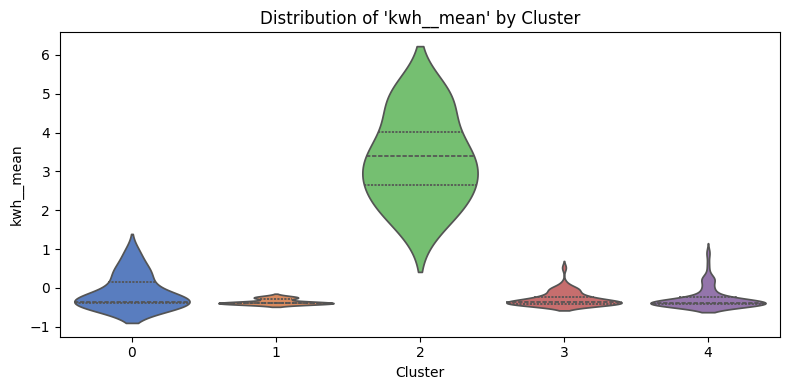

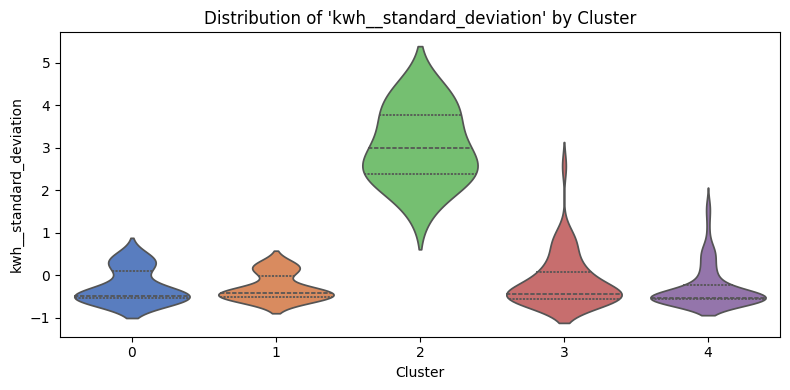

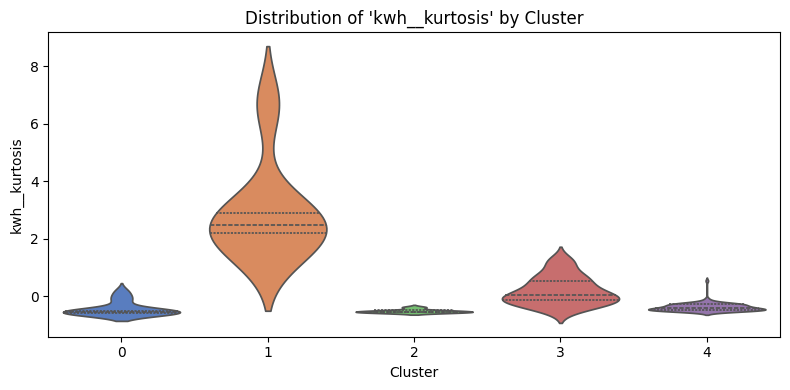

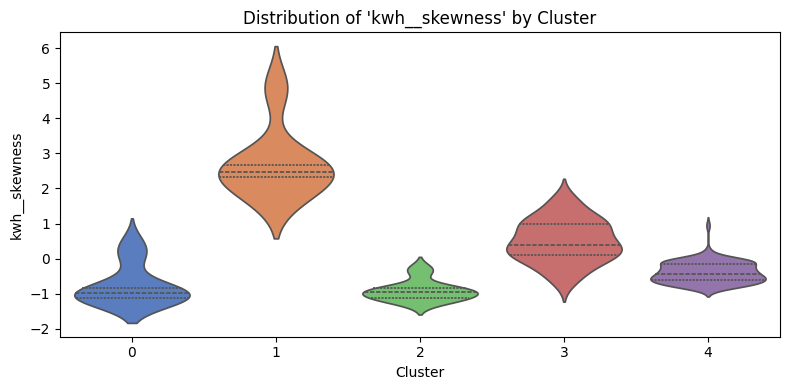

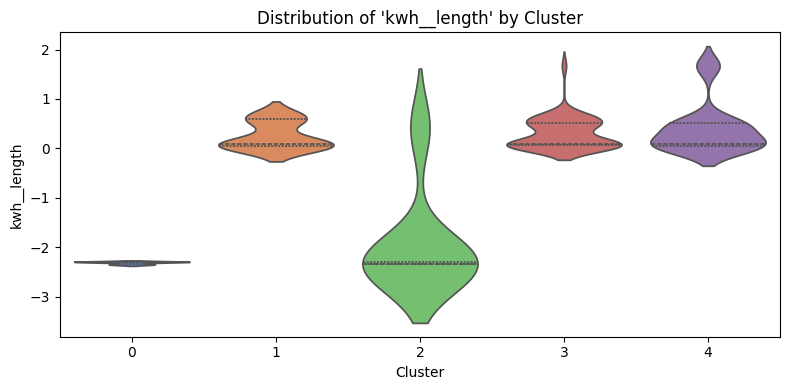

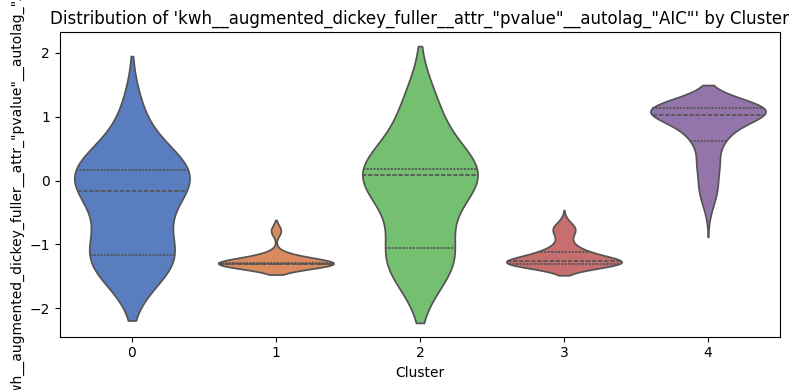

In [17]:
# Select features to plot (avoid the cluster column)
features_to_plot = [col for col in scaled_features_df.columns if col != "cluster"]

# Create violin plots for each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.violinplot(data=scaled_features_df, x="cluster", y=feature, inner="quartile", palette="muted")
    plt.title(f"Distribution of '{feature}' by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

In [7]:
con.close()

## Lessons Learned

While I think that the feature extraction and clustering is a good idea, I did not pursue the idea fully. In hindsight:
- I should have either abandoned the ADF test completely or used it for a binary split of the data into stationary and non-stationary series.
- I could have used features like mean, length and standard deviation to group the series into different training sets for different models.
- Given the groupings I could have used the different models to make a powerful ensemble model (like the winner's solution).

Overall, I think this method is powerful, but you need to really critically think about what you are looking for when doing this... I was just pursuing it on a whim.